### 데이터 셋 구축하기

In [4]:
import xml.etree.ElementTree as ELT
from bs4 import BeautifulSoup
import pandas as pd

In [5]:
data = pd.read_csv("./writers.csv")
df = pd.read_csv("./writers_with_features.csv")
print(df.info())

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7971 entries, 0 to 7970
Data columns (total 66 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         7971 non-null   int64  
 1   Unnamed: 0                 7971 non-null   int64  
 2   AcceptedAnswerId           4124 non-null   float64
 3   AnswerCount                7971 non-null   int64  
 4   Body                       7971 non-null   object 
 5   ClosedDate                 969 non-null    object 
 6   CommentCount               7971 non-null   int64  
 7   CommunityOwnedDate         17 non-null     object 
 8   CreationDate               7971 non-null   object 
 9   FavoriteCount              3307 non-null   float64
 10  Id.1                       7971 non-null   int64  
 11  LastActivityDate           7971 non-null   object 
 12  LastEditDate               4711 non-null   object 
 13  LastEditorDisplayName      123 non-null    objec

In [6]:
questions_with_accepted_answer = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())]
q_and_a = questions_with_accepted_answer.join(
    df[["body_text"]], on="AcceptedAnswerId", how="left", rsuffix="_answer"
)

pd.options.display.max_colwidth = 500
q_and_a[["body_text", "body_text_answer"]][:5]

,body_text,body_text_answer
0,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n","Writing is something that I have wanted to do for some time, and I know that I don't currently have the skill set to do more than putter. Are there any shared world story sites that exist? A collaborative site for me to get my feet wet handling a supporting character or two, rather than trying to wrangle the whole plot, would be ideal.\n"
1,"What kind of story is better suited for each point of view? Are there advantages or disadvantages inherent to them?\nFor example, writing in the first person you are always following a character, while in the third person you can ""jump"" between story lines.\n","One of the major mantras of writing fiction is ""show, don't tell"".\nIs it ever okay to tell? When?\n"
2,"I finished my novel, and everyone I've talked to says I need an agent. How do I find one?\n","If I have an excellent idea for a story, would it be wiser to write on paper first or start directly on the computer? There are many different reasons for beginning stories on paper as well as on the computer and I'd like to know about the different advantages of each side.\n"
4,"I keep hearing about literary fiction, and how it is so much better than genre fiction. What exactly is literary fiction?\n","A while ago, I played around with a short story idea in a genre I don't normally write (Young Adult fiction). The story took on a life of its own, growing quickly to a novella, and now is definitely a novel, trying to stretch itself to a series.\nThe story itself is going great, I'm just not sure where/how to break it up for a YA audience. Specifically, I expect the content to be most appealing to the pre/young-teen crowd (12-14). So far (it's still not completely mapped out) there are se..."
6,I heard a writer talking about pantsing a story. What does that mean?\n,"Late October I decided to take the plunge and attempt NaNoWriMo. I haven't done much writing in some time and thought it would be a fun attempt to jump back into things. So far it's been pretty fun getting back into writing about something I hashed together from a weird dream.\nBut I'm also woefully under the NaNoWriMo average at 8111 words. Most of my writing happens during my train commutes to and from work via train. I've averaged to about 400ish words a day, which wont get me anywhere ne..."


In [7]:
received_answers = df[df['is_question'] & (df["AnswerCount"]!=0)]
has_accepted_answer = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())]

print("총 질문: %s개, 1개 이상의 답변을 가진 질문 : %s개, 답변이 채택된 질문: %s개" % (len(df['is_question']), len(received_answers),
                                                            len(has_accepted_answer)))

총 질문: 7971개, 1개 이상의 답변을 가진 질문 : 7827개, 답변이 채택된 질문: 4124개


### 데이터셋 EDA

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

AttributeError: 'Rectangle' object has no property 'hisstype'

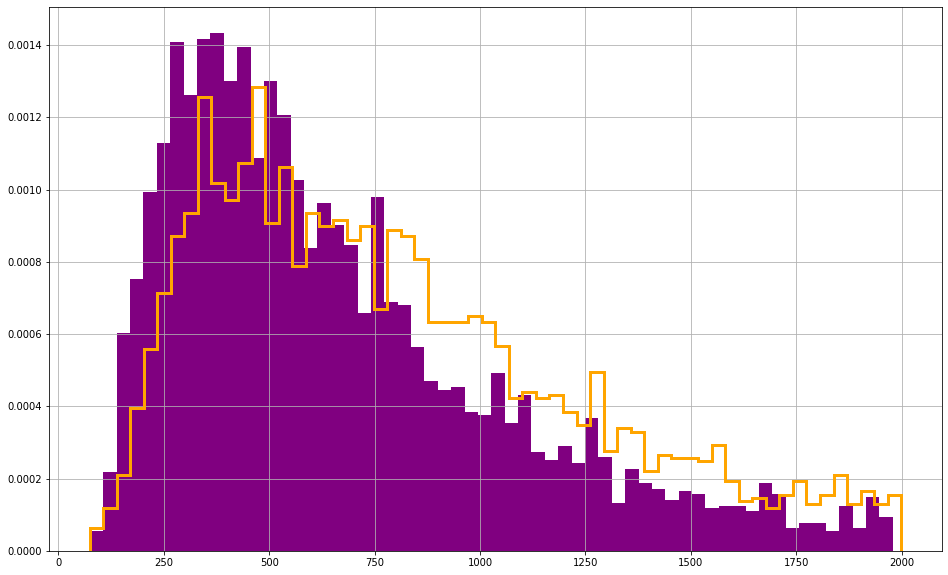

In [13]:
high_score = df['Score'] > df['Score'].median()
normal_length = df['text_len'] < 2000

ax = df[df["is_question"] & high_score & normal_length]["text_len"].hist(
    bins=60,
    density=True,
    histtype="step",
    color="orange",
    linewidth=3,
    grid="False",
    figsize=(16,10),
)

df[df['is_question'] & ~high_score & normal_length]["text_len"].hist(
    bins=60,
    density=True,
    histtype="step",
    color="purple",
    linewidth=3,
    grid=False,
)

handles = [
        Rectangle((0,0), 1,1, color=c, ec="k") for c in ["orange", "purple"]
]
labels = ["High score", "Low score"]
plt.legend(handles, labels)
ax.set_xlabel("Sentence length (characters)")
ax.set_ylabel("Percentage of sentences")